In [59]:
# !pip install dataframe-image 
import dataframe_image as dfi
# !pip install playsound pygobject
from playsound import playsound

import pandas as pd
import numpy as np
import torch
from torch import nn
from pathlib import Path
from matplotlib import pyplot as plt

In [61]:
from pathlib import Path
from matplotlib import pyplot as plt

CHAPTER = 'ch07'
BOOK_IMAGES_DIR = Path.home() / 'code' / 'tangibleai' / 'nlpia-manuscript' 
BOOK_IMAGES_DIR /= Path('manuscript') / 'images' / CHAPTER
CODE_IMAGES_DIR = Path.home() / 'code' / 'tangibleai' / 'nlpia2' / 'src' / 'nlpia2' / 'images' / CHAPTER 
IMAGES_DIR = CODE_IMAGES_DIR
IMAGES_DIR.mkdir(exist_ok=True,parents=True)

def savefig(ax, filename, **kwargs):
    filepath = IMAGES_DIR / filename
    if isinstance(ax, (list, tuple)):
        ax = ax[0]
    if hasattr(ax, 'figure'):
        return ax.figure.savefig(filepath, **kwargs)
    if hasattr(ax, 'savefig'):
        return ax.savefig(filepath, **kwargs)
    return plt.savefig(filepath)


In [3]:
# .Chapter imports

HOME_DATA_DIR = Path.home() / '.nlpia2-data'

---

# Adverby quote

In [4]:
from nlpia2.init import maybe_download
import spacy
import yaml
pd.options.display.max_columns = 10

nlp = spacy.load('en_core_web_md')
filepath = maybe_download('quotes.yml')
print(filepath)
quotes = yaml.full_load(filepath.open())
print(str(quotes)[:170])

/home/hobs/.nlpia2-data/quotes.yml
[{'text': "It's no use, Mr. James—it's turtles all the way down.", 'author': 'J. R. Ross', 'source': '_Constraints on Variables in Syntax_, 1967', 'tags': ['recursion', '


In [5]:
# .Listing 7.2 find adverby quotes

df = []
adverby_quotes = []

for i, q in enumerate(quotes):
    text = q['text']
    df.append([t.pos_ for t in nlp(text)])             # <1>
    df[-1] = [1 if p == 'ADV' else 0 for p in df[-1]]  # <2>
    bits = df[-1]
    if (1, 1) in zip(bits[:-1], bits[1:]):             # <3>
        adverby_quotes.append(i)

df = pd.DataFrame(df).iloc[adverby_quotes]
pd.options.display.max_rows = 7
print(df.fillna(''))

# <1> spacy tags words with their parts-of-speech and lots of other useful things
# <2> create a sequence of 0s and ones, 1 for an adverb, 0 for anything else
# <3> detect 2-grams of [1, 1] or ['ADV', 'ADV'] 

     0    1    2    3    4    ...  442  443  444  445 446
1      0    0    0    0  0.0  ...                        
22     0    0    0    1  0.0  ...                        
24     0    0    0    0  0.0  ...                        
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..
231    1    1    0    0  0.0  ...                        
233    1    1    0    0  0.0  ...                        
242    0    0    0    0  0.0  ...                        

[27 rows x 447 columns]


In [6]:
import dataframe_image as dfi
filepath = IMAGES_DIR / 'all-2-consecutive-adverb-quotes.df.png'
dfi.export(df.fillna(''), filepath, max_rows=7, max_cols=10)

[0527/123521.262667:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0527/123521.301490:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0527/123521.650666:INFO:headless_shell.cc(659)] Written to file /tmp/tmp8u2hifex/temp.png.


In [7]:
# df['len'] = (df > -1).sum(axis=1)
# df = df.sort_values('len')
# shortest5 = df[:5]

In [8]:
# Listing 7.3
# .Parse and tag the quote's words with SpaCy

df['len'] = (df > -1).sum(axis=1)  # <1>
df = df.sort_values('len')
quote = quotes[df.index.values[2]]
doc = nlp(quote['text'])

print(doc)

# <1> the NaN padding in the dataframe will cause all conditionals (>, <, ==) to return False

The right word may be effective, but no word was ever as effective as a rightly timed pause.


In [9]:
# // Listing 7.4
# .Tag a quote with parts of speech

tagged_quote = [
    (int(t.pos_ == 'ADV'), t.pos_, t.text)  # <1>
    for t in doc]

df_quote = pd.DataFrame(
    tagged_quote,
    columns='is_adv POS word'.split())

pd.options.display.max_rows = 20
print(df_quote)

# <1> create a binary sequence to indicate adverb occurrences

    is_adv    POS       word
0        0    DET        The
1        0    ADJ      right
2        0   NOUN       word
3        0    AUX        may
4        0    AUX         be
5        0    ADJ  effective
6        0  PUNCT          ,
7        0  CCONJ        but
8        0    DET         no
9        0   NOUN       word
10       0    AUX        was
11       1    ADV       ever
12       1    ADV         as
13       0    ADJ  effective
14       0    ADP         as
15       0    DET          a
16       1    ADV    rightly
17       0   VERB      timed
18       0   NOUN      pause
19       0  PUNCT          .


In [10]:
filepath = IMAGES_DIR / 'tagged-adverby-quote.df.png'
dfi.export(df_quote, filepath, max_rows=15)

[0527/123522.046798:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0527/123522.087983:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0527/123522.380914:INFO:headless_shell.cc(659)] Written to file /tmp/tmp97rs8jlo/temp.png.


In [11]:
# // Listing 7.5
# .Define your input sequence for convolution

inpt = list(df_quote['is_adv'])
print(inpt)

# [0, 0, 0, ... 0, 1, 1, 0, 0...]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]


---

# Pure python convolution

## (2-day moving average)

In [12]:
# // Listing 7.6
# .Convolution in pure python

kernel = [.5, .5]                        # <1>

output = []
for i in range(len(inpt) - 1):           # <2>
    z = 0
    for k, weight in enumerate(kernel):  # <3>
        z = z + weight * inpt[i + k]
    output.append(z)

print(f'inpt:\n{inpt}')
print(f'len(inpt): {len(inpt)}')
print(f'output:\n{[int(o) if int(o)==o else o for o in output]}')
print(f'len(output): {len(output)}')

# <1> the kernel weights .5 and .5 create a 2-gram moving average convolution
# <2> iterate over this is_adv seq and stop at second to last position so window doesn't slide off the end
# <3> iterate over the 2 weights in the kernel

inpt:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]
len(inpt): 20
output:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 1, 0.5, 0, 0, 0.5, 0.5, 0, 0]
len(output): 19


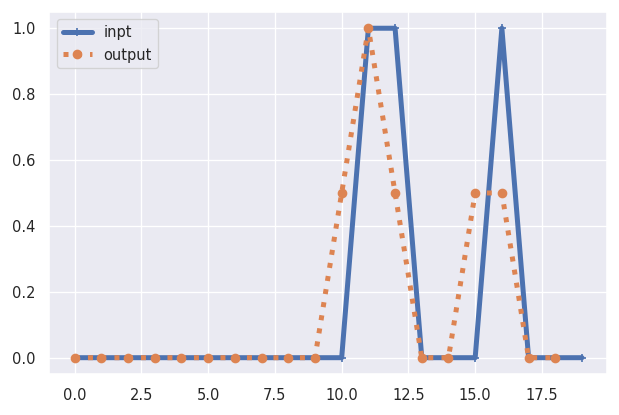

In [13]:
# // Listing 7.7
# .Line plot of input (is_adv) and output (adverbiness)

import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 120 # <1>

import seaborn as sns
sns.set_theme('paper')  # <2>

df = pd.DataFrame([inpt, output], index=['inpt', 'output']).T
ax = df.plot(style=['+-', 'o:'], linewidth=3)

# <1> the default DPI setting is 75, so 120 increases the figure size
# <2> 'notebook', 'talk', 'paper', or 'poster' will change the style of the plot

In [14]:
savefig(ax, IMAGES_DIR / 'square-wave-pure-python.png')

### Diagram idea from Chukwudi

```text
inpt =    [1,   2,   0,   -1,   -2,   0,   1,     2]
kernel =  [.5, .5,]
          .5 * 1 + .5 * 2
          1.5 

              [.5,  .5]
               .5 * 2 + .5 * 0
               1.0

                [.5,  .5]
                      [.5,  .5]
                            [.5,  .5]
                                    [.5,  .5]
                                         [.5,  .5]

[1.5, 1.0, -0.5, -1.5, -1.0, 0.5, 1.5]
```

In [15]:
def convolve(inpt, kernel, aggregator=sum):       # <1>
    output = []
    for i in range(len(inpt) - len(kernel) + 1):  # <2>
        output.append(
            aggregator(
                [
                    inpt[i + k] * kernel[k]
                    for k in range(len(kernel))  # <3>
                ]
            )
        )
    return output

# <1> min, max, sum, np.mean, np.std
# <2> stop the convolution before the kernel slides off the end  
# <3> the inner list comprehension iterates over the kernel length 

In [16]:
convolve(inpt=inpt, kernel=[1, 1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1, 0, 0]

`[3, 1, -3, -3, -1, 3]`

----

# Pytorch convolution example (adveribness score)

In [17]:
# data = np.arange(
#     num_examples * seq_len * embedding_size,
#     dtype=np.float32,
# )
# data = data.reshape(num_examples, seq_len * embedding_size)
# df = pd.DataFrame(data)

# IMAGES_DIR = Path.home() / 'code' / 'tangibleai' / 'nlpia-manuscript' / 'manuscript' / 'images' / 'ch07'
# dfi.export(df, IMAGES_DIR / 'df-minimal-cnn-dataset.png', max_rows=7)

In [18]:
import torch
from torch import nn

In [19]:
# FIXME: make previous pure python example data same as this one

kernel = [.5, -.5]  # <1>
bias = .01
# embedding_size = 1
num_channels = 1

In [20]:
x = [1, 1, 1, 0, 0, 0, 1, 1, 1]
seq_len = len(x)
x = np.array(x, np.float32)
x = torch.tensor(x)
print(f"x.resize_({num_channels}, {num_channels}, {seq_len})")
print(x.resize_(num_channels, num_channels, seq_len))

x.resize_(1, 1, 9)
tensor([[[1., 1., 1., 0., 0., 0., 1., 1., 1.]]])


In [21]:
stride = 1

conv = nn.Conv1d(
    in_channels=num_channels,
    out_channels=num_channels,
    # groups=None,
    stride=stride,
    kernel_size=len(kernel)
)
print()
print(f"conv = nn.Conv1d({num_channels}, {num_channels}, stride={stride}, kernel_size={len(kernel)})")
print(conv)


conv = nn.Conv1d(1, 1, stride=1, kernel_size=2)
Conv1d(1, 1, kernel_size=(2,), stride=(1,))


In [22]:
print()
print('conv.weight')
print(conv.weight)
print()
print('conv.bias')
print(conv.bias)


conv.weight
Parameter containing:
tensor([[[-0.3737,  0.3593]]], requires_grad=True)

conv.bias
Parameter containing:
tensor([-0.5032], requires_grad=True)


In [23]:
state = conv.state_dict()
print('state (conv.state_dict()):')
print(state)

state (conv.state_dict()):
OrderedDict([('weight', tensor([[[-0.3737,  0.3593]]])), ('bias', tensor([-0.5032]))])


In [24]:
state['weight'] = torch.tensor(np.array([[kernel]], dtype=np.float32))
state['bias'] = torch.tensor([bias])
print('updated state:')
print(state)

updated state:
OrderedDict([('weight', tensor([[[ 0.5000, -0.5000]]])), ('bias', tensor([0.0100]))])


In [25]:
conv.load_state_dict(state)
print('updated conv:')
print(conv)
print(conv.weight)
print(conv.bias)

updated conv:
Conv1d(1, 1, kernel_size=(2,), stride=(1,))
Parameter containing:
tensor([[[ 0.5000, -0.5000]]], requires_grad=True)
Parameter containing:
tensor([0.0100], requires_grad=True)


In [26]:
x = conv.forward(x)
print('x = conv.forward(x): ')
print(x)

x = conv.forward(x): 
tensor([[[ 0.0100,  0.0100,  0.5100,  0.0100,  0.0100, -0.4900,  0.0100,
           0.0100]]], grad_fn=<ConvolutionBackward0>)


In [27]:
pool_size = 3
pool_stride = 2
pool = nn.MaxPool1d(pool_size, pool_stride)
print(f"pool = nn.MaxPool1d({pool_size}, {pool_stride})")
print(pool)

pool = nn.MaxPool1d(3, 2)
MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


In [28]:
pool.forward(x)
print('x = pool.forward(x): ')
print(x)

x = pool.forward(x): 
tensor([[[ 0.0100,  0.0100,  0.5100,  0.0100,  0.0100, -0.4900,  0.0100,
           0.0100]]], grad_fn=<ConvolutionBackward0>)


----

# Morse code audio

In [29]:
# .Listing 7.L download secret message

from nlpia2.init import maybe_download

url = 'https://upload.wikimedia.org/wikipedia/' \
      'commons/7/78/1210secretmorzecode.wav'
filepath = maybe_download(url)
print(filepath)

/home/hobs/.nlpia2-data/1210secretmorzecode.wav


In [30]:
# .Listing 7.L Load the secret Morse code wav file

from pathlib import Path
from scipy.io import wavfile

filepath = HOME_DATA_DIR / '1210secretmorzecode.wav'
sample_rate, audio = wavfile.read(filepath)
print(f'sample_rate: {sample_rate}')
print(f'audio (shape={audio.shape}, dtype={audio.dtype}):\n{audio}')

sample_rate: 4000
audio (shape=(962304,), dtype=uint8):
[255   0 255 ...   0 255   0]


In [31]:
import playsound
playsound.playsound(filepath, block=False)

In [32]:
! kill -9 $(ps aux | grep playsound | cut -c12-16)

In [33]:
# .Listing 7.L Normalize and downsample the audio signal

import numpy as np
import pandas as pd
pd.options.display.max_rows = 7

audio = audio[:sample_rate * 2]                 # <1>
audio = np.abs(audio - audio.max() / 2) - .5    # <2>
audio = audio / audio.max()                     # <3>
audio = audio[::10]                             # <4>
sample_rate /= 10
audio = pd.Series(audio, name='audio')
audio.index = 1000 * audio.index / sample_rate  # <5>
audio.index.name = 'Time (ms)'
print(f'sample_rate: {sample_rate}')
print(f'audio:\n{audio}')

# <1> pull out a 2 second clip from the audio data
# <2> rectify and center the oscillating signal
# <3> normalize the signal (convert to 0s and 1s)
# <4> downsample to only 400 samples in 2 seconds (200 Hz)
# <5> convert sample (row) number to milliseconds

sample_rate: 400.0
audio:
Time (ms)
0.0       1.0
2.5       1.0
5.0       1.0
         ... 
1992.5    0.0
1995.0    0.0
1997.5    0.0
Name: audio, Length: 800, dtype: float64


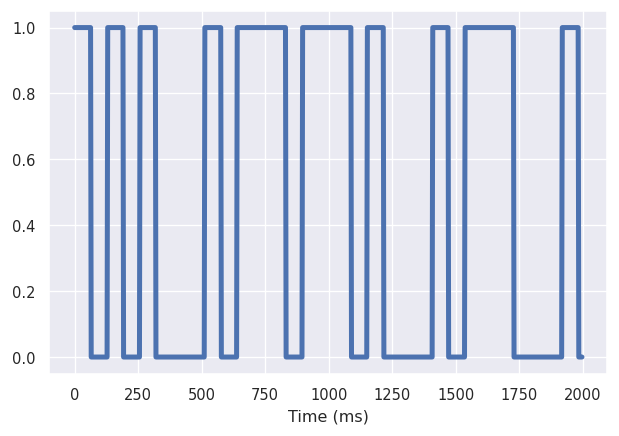

In [34]:
ax = audio.plot(linewidth=3)

In [35]:
ax.figure.savefig(IMAGES_DIR / 'morse-code-wav-plot-preprocessed.png')

---

# Morse code audio dot-detecting convolution

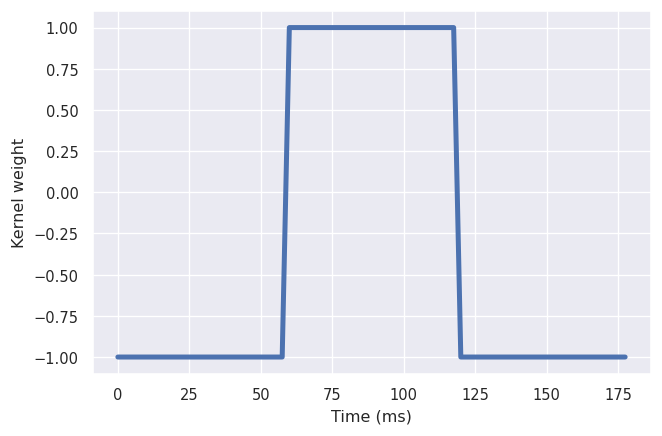

In [36]:
# .Dot detecting kernel

kernel = [-1] * 24 + [1] * 24 + [-1] * 24                      # <1>
kernel = pd.Series(kernel, index=2.5 * np.arange(len(kernel)))
kernel.index.name = 'Time (ms)'
ax = kernel.plot(linewidth=3, ylabel='Kernel weight')

# <1> 24 samples (2.5 ms each) adds up to 60 ms for each of the low, high, low segments

In [37]:
ax.figure.savefig(IMAGES_DIR / 'dot-detecting-kernel.png')

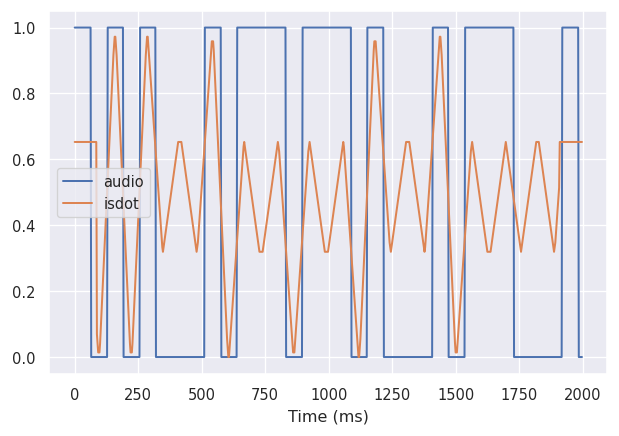

In [38]:
# .Dot detector convolved with the secret message

kernel = np.array(kernel) / sum(np.abs(kernel))  # <1>
pad = [0] * (len(kernel) // 2)                   # <2>
isdot = convolve(audio.values, kernel)
isdot =  np.array(pad[:-1] + list(isdot) + pad)  # <3>

df = pd.DataFrame()
df['audio'] = audio
df['isdot'] = isdot - isdot.min()
ax = df.plot()

# <1> Normalize your kernel by dividing by the sum of the absolute value of the kernel weights
# <2> You will pad both sides by half the amount of data that the kernel "lost"
# <3> You lose `len(kernel) - 1` signal values, so your padding is 1 short on one side

In [39]:
savefig(ax, 'hand-crafted-dot-detector-convolution.png')

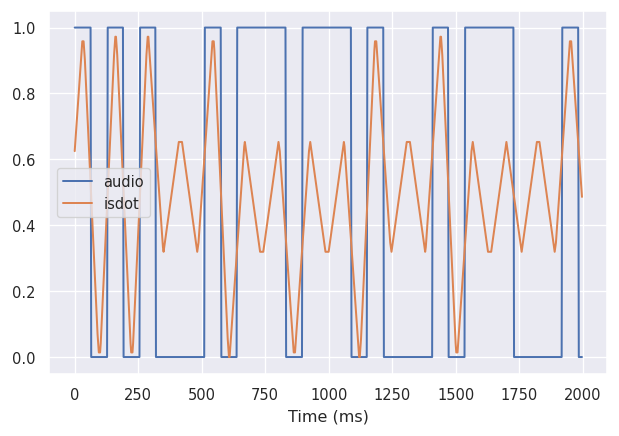

In [40]:
# .Numpy convolve

isdot = np.convolve(audio.values, kernel, mode='same')  # <1>
df['isdot'] = isdot - isdot.min()
ax = df.plot()

# <1> np.convolve has 3 possible modes: 'same', 'full', or 'valid' 

In [41]:
savefig(ax, 'hand-crafted-dot-detector-numpy-convolution.png')

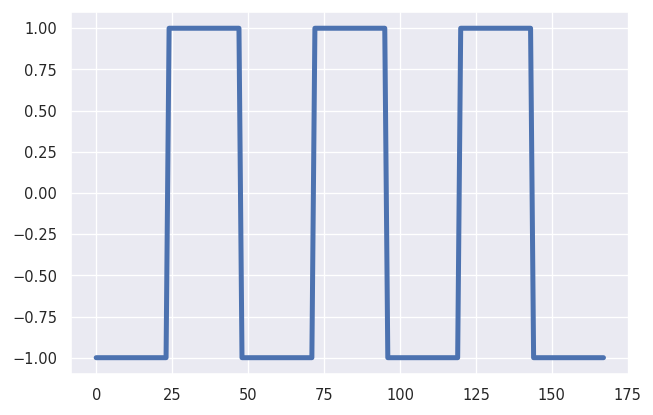

In [42]:
s_kernel = ([-1] * 24 + [1] * 24) * 3 + [-1] * 24
plt.plot(s_kernel, linewidth=3)

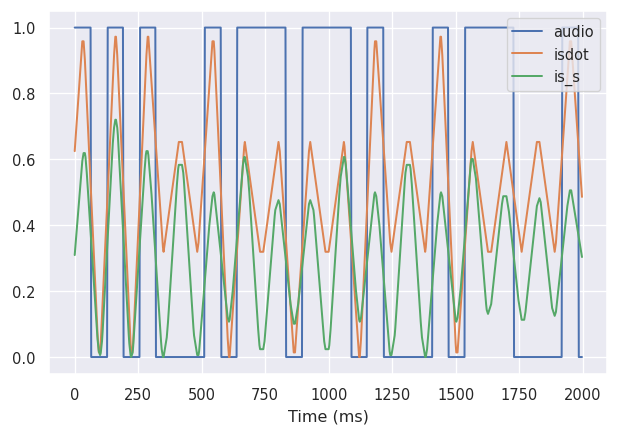

In [43]:
# UNUSED

s_kernel = np.array(s_kernel) / sum(np.abs(s_kernel))
is_s = np.convolve(audio.values, s_kernel, mode='same') 
df['is_s'] = is_s - is_s.min()
ax = df.plot()


In [44]:
savefig(ax, 's-kernel-convolved-with-secret-message.png')

In [45]:
# .Learnable embedding layer

from torch import nn

embedding = nn.Embedding(
    num_embeddings=3000,  # <1>
    embedding_dim=50,     # <2>
    padding_idx=0)

# <1> you must use the same size here as you use in your tokenizer
# <2> the smallest useful GloVE embeddings have 50 dimensions

In [46]:
embedding

Embedding(3000, 50, padding_idx=0)

In [47]:
# Listing 7.TBD12
# .Load news posts

df = pd.read_csv(HOME_DATA_DIR / 'news.csv')
df = df[['text', 'target']]  # <1>
print(df)

# <1> you only need the text and binary newsworthiness label for your CNN training

                                                   text  target
0     Our Deeds are the Reason of this #earthquake M...       1
1                Forest fire near La Ronge Sask. Canada       1
2     All residents asked to 'shelter in place' are ...       1
...                                                 ...     ...
7850  And in its broadest sense, neural Darwinism im...      -1
7851  In the 1980's, Edelman's theory was so novel t...      -1
7852  Over a lifetime, I have written millions of wo...      -1

[7853 rows x 2 columns]


In [48]:
# // Listing 7.TBD13
# .Most common words for your vocabulary

import re
from collections import Counter
from itertools import chain

counts = Counter(chain(*[
    re.findall(r'\w+', t.lower()) for t in df['text']]))     # <1>
vocab = [tok for tok, count in counts.most_common(4000)[3:]] # <2>
vocab += ['sacred']

print(counts.most_common(6))

# <1> tokenizing, case folding, and occurrence counting
# <2> ignore the 3 most frequent tokens ("t", "co", "http")


[('t', 5235), ('co', 4740), ('http', 4309), ('the', 3667), ('a', 2366), ('to', 2185)]


In [49]:
# // Listing 7.TBD14 
# .Multipurpose padding function

def pad(sequence, pad_value, seq_len):
    padded = list(sequence)[:seq_len]
    padded = padded + [pad_value] * (seq_len - len(padded))
    return padded

In [50]:
# .Load embeddings and align with your vocabulary

from nessvec.files import load_vecs_df

glove = load_vecs_df(HOME_DATA_DIR / 'glove.6B.50d.txt')
vocab = [tok for tok in vocab if tok in glove.index]         # <1>
embed = glove.loc[vocab]                                     # <2>

print(f'embed.shape: {embed.shape}')
print(f'vocab:\n{pd.Series(vocab)}')

# <1> skip unknown embeddings; alternatively create zero vectors
# <2> ensure your embedding matrix is in the same order as your vocab

2022-05-27:12:35:27.193 DEBUG files.py:271 skiprows=1


embed.shape: (3846, 50)
vocab:
0             a
1            to
2            in
         ...   
3843    objects
3844     chases
3845     sacred
Length: 3846, dtype: object


In [51]:
# Figure 7.TBD
# cnn-embeddings-glove-words-are-sacred.drawio.png

words = embed.loc[['words', 'are', 'sacred']].T
words['.'] = 0.0
words['<pad>'] = 0.0
roundwords = words.round(2)
roundwords

,words,are,sacred,.,<pad>
0,-0.07,0.96,0.38,0.0,0.0
1,0.66,0.01,1.32,0.0,0.0
2,-0.06,0.22,-1.54,0.0,0.0
...,...,...,...,...,...
47,0.82,0.14,-0.51,0.0,0.0
48,-0.54,-0.38,-0.70,0.0,0.0
49,-0.00,-0.39,-1.41,0.0,0.0


In [52]:
class CNNTextClassifier(nn.Module):

    def __init__(self, vocab_size=5, embedding_size=50):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=5,
            embedding_dim=50,
            padding_idx=0)
        self.conv = nn.Conv1d(
            in_channels=50,
            out_channels=50,
            groups=50,
            kernel_size=2,
            stride=1)
    
    def forward(self, x):
        
        embeddings = self.embedding(x)
        print(f"embeddings.size(): {embeddings.size()}")
        print(f"embeddings:\n{embeddings}")
        features = self.conv(embeddings)
        print(f"features.size(): {features.size()}")
        print(f"features:\n{features}")
        return features.squeeze()
#             z = torch.relu(z)
#             z = pool(z)
#             conv_outputs.append(z)


In [54]:
import torch
cnn = CNNTextClassifier()
index_seq = torch.tensor([[1, 2, 3, 4] + [0] * 46 ])
print(f"index_seq.dtype: {index_seq.dtype}")
print(f"index_seq.size(): {index_seq.size()}")
cnn.forward(index_seq)

index_seq.dtype: torch.int64
index_seq.size(): torch.Size([1, 50])
embeddings.size(): torch.Size([1, 50, 50])
embeddings:
tensor([[[-1.0081, -1.1699, -1.4963,  ...,  2.3020,  0.2489,  0.5018],
         [-0.2400, -0.6480, -1.3521,  ...,  0.5758, -1.1413,  1.3931],
         [-0.3120,  0.6063,  1.8722,  ..., -0.8434, -0.6202, -0.5454],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<EmbeddingBackward0>)
features.size(): torch.Size([1, 50, 49])
features:
tensor([[[ 0.7111,  0.7006,  0.8373,  ...,  1.6108, -0.9101,  0.4913],
         [ 0.3074, -0.0479, -0.0912,  ...,  0.9394,  0.0321,  1.3873],
         [ 0.7862,  1.0993,  0.8208,  ...,  0.5600,  0.5075,  0.5376],
         ...,
         [ 0.3920,  0.3920,  0.3920,  ...,  0.3920,  0.3920,  0.3920],
         [ 0.0987,  0.0987,  0.0987,  ...,  0.0987

tensor([[ 0.7111,  0.7006,  0.8373,  ...,  1.6108, -0.9101,  0.4913],
        [ 0.3074, -0.0479, -0.0912,  ...,  0.9394,  0.0321,  1.3873],
        [ 0.7862,  1.0993,  0.8208,  ...,  0.5600,  0.5075,  0.5376],
        ...,
        [ 0.3920,  0.3920,  0.3920,  ...,  0.3920,  0.3920,  0.3920],
        [ 0.0987,  0.0987,  0.0987,  ...,  0.0987,  0.0987,  0.0987],
        [-0.3255, -0.3255, -0.3255,  ..., -0.3255, -0.3255, -0.3255]],
       grad_fn=<SqueezeBackward0>)

In [55]:
filepath = Path('df-glove-vectors-sacred-pad-1.png')
if filepath.is_file():
    filepath.unlink()
dfi.export(roundwords, filepath, max_rows=7)

[0527/123616.744617:WARNING:bluez_dbus_manager.cc(248)] Floss manager not present, cannot set Floss enable/disable.
[0527/123616.786132:ERROR:sandbox_linux.cc(377)] InitializeSandbox() called with multiple threads in process gpu-process.
[0527/123617.056794:INFO:headless_shell.cc(659)] Written to file /tmp/tmp2hzke_7k/temp.png.


![df-glove-vectors-sacred-pad.png](df-glove-vectors-sacred-pad.png)

In [56]:
# .Initialize your embedding layer with GloVE vectors

import torch
embed = torch.Tensor(embed.values)                         # <1>
print(f'embed.size(): {embed.size()}')
embed = nn.Embedding.from_pretrained(embed, freeze=False)  # <2>
print(embed)

# <1> convert Pandas DataFrame to a torch.Tensor
# <2> freeze=False allows your Embedding layer to fine-tune your embeddings

embed.size(): torch.Size([3846, 50])
Embedding(3846, 50)


In [57]:
# .Initialize your CNN hyperparameters

class CNNTextClassifier(nn.Module):

    def __init__(self, embeddings=glove):
        super().__init__()

        self.seq_len = 35                         # <1>
        self.vocab_size = embeddings.shape[0]
        self.embedding_size = embeddings.shape[1]
        self.kernel_lengths = [2]                 # <2>
        self.stride = 2
        self.conv_output_size = 50                # <3>

        self.dropout = nn.Dropout(.2)

        self.embedding = nn.Embedding(self.vocab_size + 1, self.embedding_size, padding_idx=0)

        self.convolvers = []
        self.poolers = []
        for i, kernel_len in enumerate(self.kernel_lengths):
            self.convolvers.append(nn.Conv1d(self.seq_len, self.conv_output_size, kernel_len, self.stride))
            self.poolers.append(nn.MaxPool1d(kernel_len, self.stride))

        self.encoding_size = self.cnn_output_size()
        self.linear_layer = nn.Linear(self.encoding_size, 1)

# <1> assume a maximum text length of 35 tokens
# <2> only one kernel layer is needed for reasonable results
# <3> the convolution output need not have the same number of channels as your embeddings


    def cnn_output_size(self):
        """ Calculate the number of encoding dimensions output from CNN layers

        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

        source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        """
        out_pool_total = 0
        for kernel_len in self.kernel_lengths:
            out_conv = ((self.embedding_size - 1 * (kernel_len - 1) - 1) / self.stride) + 1
            out_conv = math.floor(out_conv)
            out_pool = ((out_conv - 1 * (kernel_len - 1) - 1) / self.stride) + 1
            out_pool = math.floor(out_pool)
            out_pool_total += out_pool

        # Returns "flattened" vector (input for fully connected layer)
        return out_pool_total * self.conv_output_size

In [58]:
np.array(embed).shape



()

In [ ]:
import json
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 40
from pathlib import Path

paths = list((Path.home() / '.nlpia2-data' / 'log').glob('*'))
df = []
for p in paths:
    d = json.load(p.open())
    df.append({k:d.get(k) for k in d.keys() if k not in ('learning_curve', 'y_test', 'y_train')})
    df[-1]['filename'] = p.name[-12:-5]
df = pd.DataFrame(df)
df.sort_values('test_accuracy').round(2).tail(10).T

In [ ]:
# FIXME: both implementations look incorrect because pooling should not add additional dimensions/sequence elements to the encoding

# .Compute the shape of the CNN output (the number of the output encoding vector dimensions)


def conv1_output_encoding_size(self, embedding_size, kernel_lengths, stride, output_channels):
    """ Calculate the number of encoding dimensions output from CNN layers

    Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
    Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

    source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
    """
    out_pool_total = 0
    for kernel_len in kernel_lengths:
        out_conv = (
            (embedding_size - 1 * (kernel_len - 1) - 1) / stride) + 1
        out_conv = math.floor(out_conv)
        out_pool = ((out_conv - 1 * (kernel_len - 1) - 1) / stride) + 1
        out_pool = math.floor(out_pool)
        out_pool_total += out_pool

    # return the len of a "flattened" vector that is passed into a fully connected (Linear) layer
    return out_pool_total



In [ ]:

def compute_output_seq_len(input_seq_len, kernel_lengths, stride):
    """ Calculate the number of encoding dimensions output from CNN layers

    From PyTorch docs:
      L_out = 1 + (L_in + 2 * padding - dilation * (kernel_size - 1) - 1) / stride
    But padding=0 and dilation=1, because we're only doing a 'valid' convolution.
    So:
      L_out = 1 + (L_in - (kernel_size - 1) - 1) // stride

    source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
    """
    out_pool_total = 0
    for kernel_len in kernel_lengths:
        out_conv = (
            (input_seq_len - 1 * (kernel_len - 1) - 1) / stride) + 1
        out_conv = math.floor(out_conv)
        out_pool = ((out_conv - 1 * (kernel_len - 1) - 1) / stride) + 1
        out_pool = math.floor(out_pool)
        out_pool_total += out_pool

    # return the len of a "flattened" vector that is passed into a fully connected (Linear) layer
    return out_pool_total


In [ ]:
import json
import pandas as pd
from pathlib import Path

pd.options.display.max_columns = 100
pd.options.display.max_rows = 40


def best_hyperparms():
    paths = list((Path.home() / '.nlpia2-data' / 'log').glob('*'))
    df = []
    for p in paths:
        d = json.load(p.open())
        df.append({k: d.get(k) for k in d.keys() if k not in ('learning_curve', 'y_test', 'y_train')})
        df[-1]['filename'] = p.name[-12:-5]
    df = pd.DataFrame(df)
    df.sort_values('test_accuracy').round(2).tail(10).T


def learning_curve(filepath=Path.home() / '.nlpia2-data' / 'log' / 'disaster_tweets_cnn_pipeline_14728.json'):
    with Path(filepath).open() as fin:
        results = json.load(fin)

    curve = pd.DataFrame(results['learning_curve'],
                         columns=['loss', 'training_accuracy', 'test_accuracy'])
    return curve

In [ ]:
curve = learning_curve()

accuracy = curve[['training_accuracy', 'test_accuracy']]
accuracy.plot(linewidth=3, xlabel='Epochs', ylabel='Accuracy')

In [ ]:
savefig(ax, IMAGES_DIR / 'learning-curve-85-80.png')